In [2]:
import numpy as np
from copy import deepcopy
from pprint import pprint
import sys, os

sys.path.append('utils/')
from modeling_analysis_utils import plot_example_traces, load_neurons, load_baier_regions, LRsplit, build_traces, load_baier_connectome, build_neural_S, oasis_decon

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
FISH_ID = 5
traces_full_filepath         = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID
mask_filepath                = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID


# tmax=None
# if fish_id== 2:
#     tmax = 1370
# elif fish_id == 3:
#     tmax = 1270
# elif fish_id == 5:
#     tmax = 2190

In [4]:
all_spatial_ids, all_spatial_coords  = load_neurons(mask_filepath, region_name=['Telencephalon -', 
                                                                     'Rhombencephalon -', 
                                                                     'Mesencephalon -', 
                                                                     'Diencephalon -', 
                                                                     'Spinal Cord'], extend=True)

## remove duplicate ids
unique_ids = []
unique_coord_idxs = []
for (idx,i) in enumerate(range(len(all_spatial_ids))):
    current_id = all_spatial_ids[i]
    if current_id not in unique_ids:
        unique_ids.append(current_id)
        unique_coord_idxs.append(idx)

all_spatial_coords = np.asarray(all_spatial_coords, dtype='float32')[unique_coord_idxs,:]
all_spatial_ids    = np.asarray(unique_ids, dtype='uint32')


# build data structure thta maps mask id to neuron ids that are present in structural connectome
midpoint                  = np.mean(all_spatial_coords, axis=0)
atlas_dict, mask2idx_dict = load_baier_regions(mask_filepath)
mask2idx_dict             = LRsplit(mask2idx_dict, midpoint, axis=0)
    
    
# extract neuron calcium traces if id present in sturcutral connectome
ftraces = np.load(traces_full_filepath)
traces  = ftraces['tracez']
ftraces.close()
roi_traces, roi_coords, mask_szs = build_traces(traces, mask2idx_dict)
roi_traces = roi_traces.astype('float32')
roi_coords = roi_coords.astype('float32')
N, T = roi_traces.shape
print(N,T)

###
structural_connectome = load_baier_connectome()
S = build_neural_S(mask2idx_dict, structural_connectome, N)


4894 2500


In [5]:
min_nonzero  = np.min(S[S > 0])
S = np.log10(S + min_nonzero)
maxS, minS = np.max(S), np.min(S)
S    = ((S - minS) / (maxS - minS))
S += min_nonzero

In [11]:
def iron_bumps(traces, tb=20, db=20):
    idxs = []
    N, T = traces.shape
    for i in range(N):
        trace = traces[i,:]
        diff = np.diff(trace,1)
        
        trace_bad = np.where(abs(trace) > tb)[0]
        diff_bad  = np.where(abs(diff) > db)[0]
        if len(trace_bad) > 0 or len(diff_bad) > 0:
            idxs.append(i)
    return idxs

tmax = 2190
#bad_idxs = iron_bumps(traces[:,10:tmax], tb=10, db=10)
#good_idxs = list(set(range(roi_traces.shape[0])) - set(bad_idxs))
#print(len(good_idxs), len(bad_idxs))

good_idxs = list(range(roi_traces.shape[0]))
print(len(good_idxs), len(bad_idxs))


4894 119


In [29]:
final_traces = roi_traces[good_idxs,:]
final_coords = roi_coords[good_idxs,:]
final_S = S[good_idxs,:]
final_S = final_S[:,good_idxs]


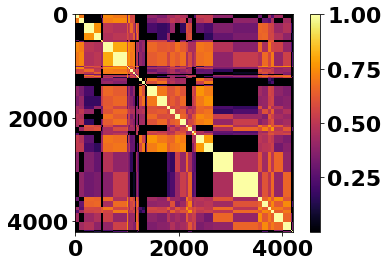

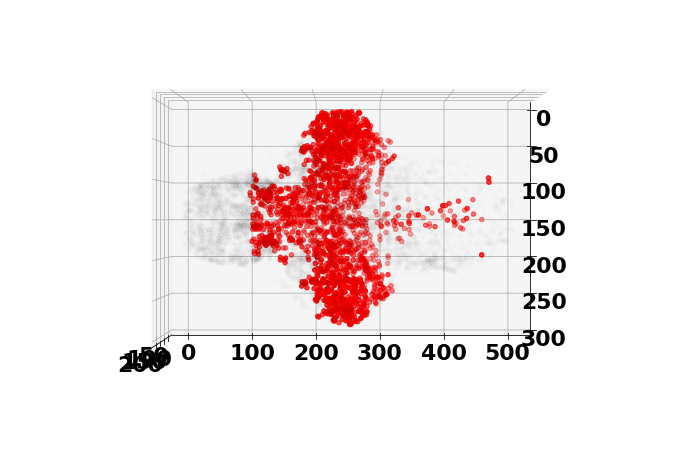

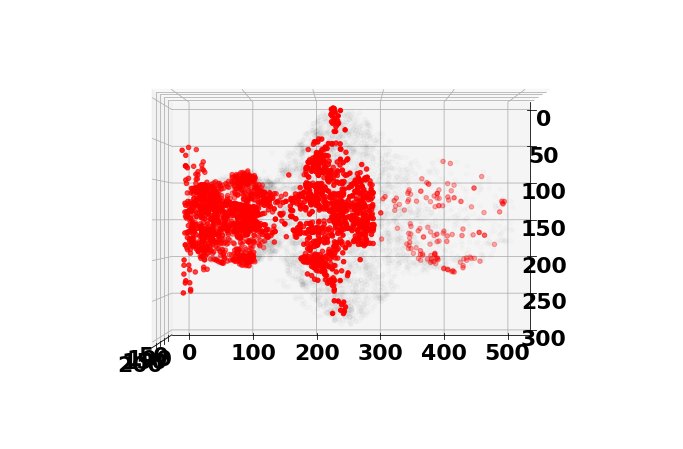

In [34]:
import scipy.cluster.hierarchy as sch

plt.figure()
plt.imshow(final_S, cmap='inferno')
plt.colorbar()
plt.show()


#hierarchical clustering and plotting on structural connectome

#d = sch.distance.pdist(final_S, metric='euclidean')
#Z = sch.linkage(d, method='ward')
#inds   = sch.fcluster(Z, 2, 'maxclust')

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*np.asarray(all_spatial_coords).T, color='k', alpha=0.01)


colors = ['r', 'b', 'g', 'c', 'm']
mini, maxi = np.min(inds), np.max(inds)
for (count, ind) in enumerate(range(mini, maxi+1)):
    roi_idxs = np.where(inds == ind)[0]
    ax.scatter(*final_coords[roi_idxs,:].T, color='r')    

ax.view_init(90,0)

In [30]:
f = np.savez('../data/fish-%i-processed-2.npz' % FISH_ID, coords=final_coords,traces=final_traces, S=final_S)

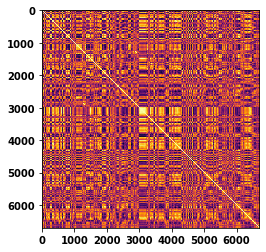

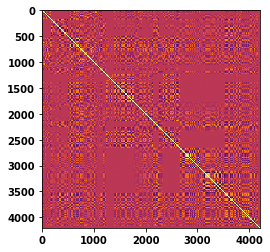

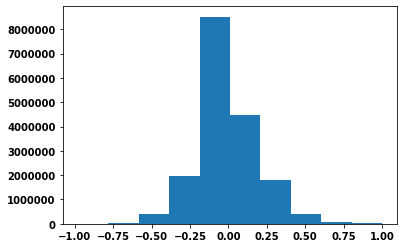

In [29]:
matrix_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f2/gt/fc-123.npz'
f = np.load(matrix_filepath)
fc = f['fc']
f.close()

plt.figure()
plt.imshow(fc, vmin=-1., vmax=1., cmap='inferno')
plt.show()

matrix_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f2-weighted/gt/fc-123.npz'
f = np.load(matrix_filepath)
fc = f['fc']
f.close()

plt.figure()
plt.imshow(fc, vmin=-1., vmax=1., cmap='inferno')
plt.show()

plt.figure()
plt.hist(fc.reshape(-1,))
plt.show()